# Sly Quoter
### Market-making algorithm based on Order Book Pressure

Robert Soczewica   
12 Feb 2021 

## Introduction

I prepared market making algorithm providing bid-ask quotes. The whole strategy is implemented in Python language with the use of OOP paradigm. Therefore the strategy itself is implemented as a class with parameters that can be tweaked and optimized independently. For this challenge I made some assumptions about the parameters, hence all of them have default values declared in class initializer.  

The class outputs bid-ask quotes for defined test period. Those can be obtained with default parameters by simply running `sly = SlyQuoter().run()` and are saved in `sly.result` attribute. However, in order to show particular methods and the logic standing behind those, I will run whole strategy step-by-step in below report. 

All Python libraries needed to run the code are listed in separate **requirements.txt** file.

## Data analysis 

Let's import some useful packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,4)
plt.style.use('fivethirtyeight')

The raw order book data stored top 100 levels in each snapshoot and looks like this:

In [2]:
from sly_quoter_class import SlyQuoter

sly = SlyQuoter()
sly.get_data(folder='binance_iotabtc_orderbooks')
sly.order_book.head()

,lastUpdated,asks,bids
0,2020-07-22 00:00:05.487,"[[2.8290000000000002e-05, 6044], [2.83e-05, 41...","[[2.8250000000000002e-05, 4103], [2.822e-05, 5..."
1,2020-07-22 00:00:05.785,"[[2.8290000000000002e-05, 6044], [2.83e-05, 41...","[[2.822e-05, 5283], [2.821e-05, 5611], [2.8199..."
2,2020-07-22 00:00:19.194,"[[2.83e-05, 4103], [2.8310000000000002e-05, 43...","[[2.823e-05, 4103], [2.822e-05, 5283], [2.821e..."
3,2020-07-22 00:00:33.903,"[[2.8290000000000002e-05, 7077], [2.83e-05, 41...","[[2.823e-05, 4103], [2.822e-05, 5283], [2.821e..."
4,2020-07-22 00:00:54.917,"[[2.83e-05, 9226], [2.8310000000000002e-05, 51...","[[2.822e-05, 8287], [2.821e-05, 5011], [2.8199..."


One observation is that the json syntax was not loaded correctly. It will be handled later. The second thing to mention is the time frame of the dataset.

In [3]:
pd.to_datetime(sly.order_book['lastUpdated']).describe()

count                          96858
unique                         96858
top       2020-07-20 14:05:36.838000
freq                               1
first     2020-07-17 00:00:23.225000
last      2020-07-30 23:59:01.545000
Name: lastUpdated, dtype: object

We can see that whole dataset is built on top of high frequency order book snapshoots through 14 days.   

In order to ease the analysis and time needed for computation I made some fundamental assumptions about the data. First assumption states that I limited the order book levels used by the strategy. The default value was set to top 5 levels, which is only a small amount of available depth, but at least allows draw some meaningful conclusions about the market microstructure. 

The second major assumption was related to the granularity of observations. I decided to aggregate them in 1 minute bars by default, but end user can choose the most feasible aggregation by herself. Thanks to this the time space was divided into equally distributed chunks, which is convenient in modelling phase (the same number of observations in each day). 

I used forward fill for resampling, which means that order book assigned to a given time bar is the last order book snapshoot we have within this time bar (close state of order book). If there were no updates in a given time bar $t$, the last available order book state was sourced automatically from previous time bar $t-1$.

As we do not have an access to earlier data than the first minute of the dataset, I replaced it not with the closing status of preceeding minute, but rather with a first available snapshoot.  

In [4]:
sly.prepare_data(time_bar=1, max_depth=5)
sly.order_book.head(10)

,bidPrice,bidAmount,askPrice,askAmount
timeStamp,,,,
2020-07-17 00:00:00,0.00002825,4103,0.00002829,6044
2020-07-17 00:00:00,0.00002822,5283,0.00002830,4103
2020-07-17 00:00:00,0.00002821,5611,0.00002831,5100
2020-07-17 00:00:00,0.00002820,2328,0.00002832,187
2020-07-17 00:00:00,0.00002819,5015,0.00002833,21146
2020-07-17 00:01:00,0.00002639,4216,0.00002645,4216
2020-07-17 00:01:00,0.00002638,4989,0.00002646,763
2020-07-17 00:01:00,0.00002637,2427,0.00002647,6640
2020-07-17 00:01:00,0.00002636,27936,0.00002648,16921


The tick size for pair IOTA/BTC is 0.00000001, hence I set the display precision in pandas to eight decimal points. 

In [5]:
sly.order_book.describe()

,bidPrice,bidAmount,askPrice,askAmount
count,100800.00000000,100800.00000000,100800.00000000,100800.00000000
mean,0.00002710,5300.79945437,0.00002718,5698.90093254
std,0.00000142,8791.16146394,0.00000142,9803.57037218
min,0.00002315,1.00000000,0.00002326,1.00000000
25%,0.00002615,507.00000000,0.00002624,1000.00000000
50%,0.00002717,4151.00000000,0.00002726,4665.00000000
75%,0.00002826,6808.00000000,0.00002835,7111.00000000
max,0.00003001,253000.00000000,0.00003011,568571.00000000


As it may be seen, there are more than 100k observations in our dataset. The bid-ask quotes are pretty low and due to that even small tick changes can result in significant percentage change. 

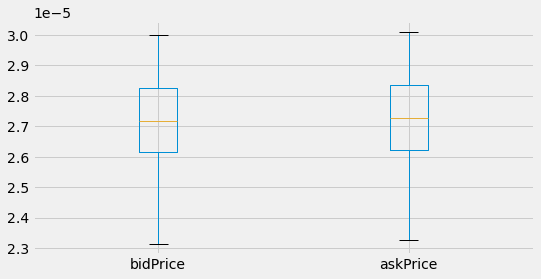

In [6]:
sly.order_book.boxplot(column=['bidPrice', 'askPrice']);

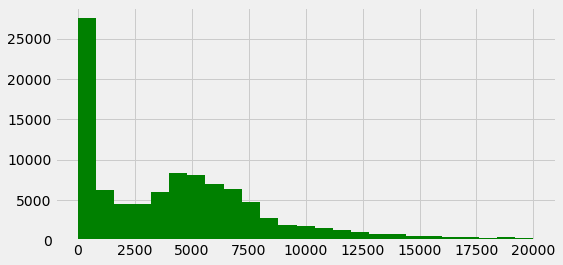

In [7]:
plt.hist(sly.order_book['bidAmount'], bins=25, range=(0, 20000), color='green');

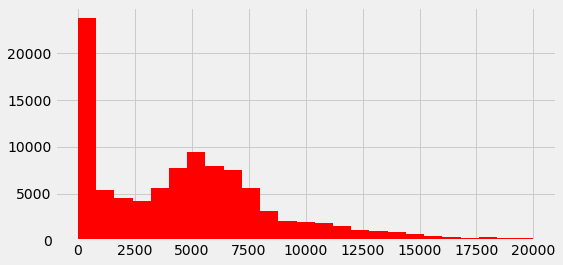

In [8]:
plt.hist(sly.order_book['askAmount'], bins=25, range=(0, 20000), color='red');

On the other hand, the limit orders amounts in top 5 levels are very differentianed as expected. These values contain a lot of outliers, which means that order sizes are irregular and prone to current market conditions and one's inventory needs. However, vast majority of transactions have small order sizes. 

To perform modelling task and further analysis, the dataset should be divided into train and test part. Due to relatively short period of daily data and intraday character of this challenge, I decided to account 90% (rounded to the full day) of the dataset for train period. This way I assure that I have enough data for training a model and to spot some trends as well as intraday movements.  

In [9]:
sly.train_test_split(train_pct=0.9)

print("Train start: ", sly.train_start) 
print("Train end: ", sly.train_end)
print("Test start: ", sly.test_start) 
print("Test end: ", sly.test_end)

Train start:  2020-07-17 00:00:00
Train end:  2020-07-29 23:59:00
Test start:  2020-07-30 00:00:00
Test end:  2020-07-30 23:59:00


Such a division results in 13 days of train data and 1 day of test data.

## Signal and features creation

In order to create a model, one needs to choose what will be the scope of modelling. I decided that I will try to model the price impact of order book structure. This topic is thoroughly described in the literature. The aim was to spot the realtionship between changes in bid-ask amounts across top order book levels and mid price (mean of the best bid and offer price). 

The basic intuition and what's more the hypothesis of this task was that if at a given time $t$ the total size of orders at sell side is bigger than the size at buy side by some threshold $\tau$, we should expect the mid price ($\frac{BestBid+BestAsk}{2}$) to go down in the near short period and vice versa. 

To calculate the realationship between bid and ask total sizes at time $t$, I employed Order Book Pressure metric:

$$ OBP(n, l) = \frac{ \sum_{i=0}^{n} \sum_{j=1}^{l} BidSize_{j,t-i} }{ \sum_{i=0}^{n} \sum_{j=1}^{l} AskSize_{j,t-i} } $$

This metric can be interpreted as a ratio between total bid and ask amounts over $l$ order book levels in the last $n$ time bars.

Although such form of the metric is flexible, it also requires some way of parameter tuning, because with different $n$ and $l$ values we may obtain completely different OBP. Thus I decided to form several features with different parameter values to avoid parameter optimization and expanded the analysis scope to spot differences among different order book depths and memory times. 

I chose $[1, 2, 3, 4, 5]$ for $l$ and $[1, 2, 3, 5, 10, 15]$ for $n$ as proposed in the literature. Then I combined each $OBP(n, l)$ variation and form 30 different features that will be treated as independent variables in modelling task.

On the other hand, the signal value which is our dependent variable will be a categorical variable that is equal to 1 if the mid price go up by some threshold $\tau$, 0 if the mid price change from time bar $t-1$ to time bar $t$ is within $(-\tau, \tau)$ range, and finally -1 if the mid price change is smaller than $-\tau$. 

The potential difficulty may be associated with the calculation of the $\tau$ threshold. I set the threshold arbitrally and automatically in my code by simply taking the average of absolute values of 0.4 and 0.6 quantiles of mid price percentage change from bar to bar over training period. The formula I proposed is as follows:

$$ MidRet_{t} = \frac{MidPrice_{t} - MidPrice_{t-1}}{MidPrice_{t-1}} $$
$$ MidRet_{train} = \sum_{i}^{t} MidRet_{i} $$
$$ \tau = \frac{|q_{0.6}(MidRet_{train})| + |q_{0.4}(MidRet_{train})|}{2} $$

I created above formula to quantify the mid price changes over train period. Hence the threshold is data driven and can adjust to different market scenarios. In my opinion the selection of 0.4 and 0.6 qunatiles allows to spot any promising movements, while still gives some robust security level, so that the signal won't change when small price movements occured. 

This assumption and threshold formula are crucial for modelling task and should be investigated deeper in the future. The threshold $\tau$ value can be also treated as a separate parameter to optimize.

Let's print example signal values:




In [10]:
y = sly.create_signal(thres=None)
y.head()


timeStamp
2020-07-17 00:00:00    0
2020-07-17 00:01:00   -1
2020-07-17 00:02:00    0
2020-07-17 00:03:00    1
2020-07-17 00:04:00   -1
Name: signal, dtype: int64

In [11]:
y.tail()

timeStamp
2020-07-30 23:55:00   -1
2020-07-30 23:56:00    0
2020-07-30 23:57:00   -1
2020-07-30 23:58:00   -1
2020-07-30 23:59:00   -1
Name: signal, dtype: int64

In [12]:
y.value_counts()

-1    7565
 1    7551
 0    5044
Name: signal, dtype: int64

As it may be observed the number of signal values that are -1 are nearly the same as number of signals that are 1. The value of 0 is less frequent which is a direct consequence of applying 0.4 and 0.6 quantiles in threshold calculation. 

In [13]:
X = sly.create_features(l_values=[1, 2, 3, 4, 5], t_values=[1, 2, 3, 5, 10, 15]) 
X.head()

,obp_1_1,obp_1_2,obp_1_3,obp_1_5,obp_1_10,obp_1_15,obp_2_1,obp_2_2,obp_2_3,obp_2_5,...,obp_4_3,obp_4_5,obp_4_10,obp_4_15,obp_5_1,obp_5_2,obp_5_3,obp_5_5,obp_5_10,obp_5_15
timeStamp,,,,,,,,,,,,,,,,,,,,,
2020-07-17 00:00:00,0.67885506,0.67885506,0.67885506,0.67885506,0.67885506,0.67885506,0.92500246,0.92500246,0.92500246,0.92500246,...,1.12252171,1.12252171,1.12252171,1.12252171,0.61071624,0.61071624,0.61071624,0.61071624,0.61071624,0.61071624
2020-07-17 00:01:00,1.00000000,0.81081871,0.81081871,0.81081871,0.81081871,0.81081871,1.84876481,1.22907576,1.22907576,1.22907576,...,1.29378724,1.29378724,1.29378724,1.29378724,1.39311936,0.95403639,0.95403639,0.95403639,0.95403639,0.95403639
2020-07-17 00:02:00,1.07684581,1.03732618,0.88519871,0.88519871,0.88519871,0.88519871,1.27672022,1.45758192,1.24888975,1.24888975,...,1.68330295,1.68330295,1.68330295,1.68330295,2.85434856,1.89084077,1.30518904,1.30518904,1.30518904,1.30518904
2020-07-17 00:03:00,0.00058936,0.39855140,0.56776777,0.59969566,0.59969566,0.59969566,0.36463504,0.79061497,0.97852837,0.96430442,...,1.99548552,1.81265012,1.81265012,1.81265012,1.49713944,2.02212216,1.75279570,1.34867816,1.34867816,1.34867816
2020-07-17 00:04:00,0.00100326,0.00074253,0.29113581,0.50427726,0.50427726,0.50427726,0.39140523,0.37714087,0.66348428,0.83822869,...,1.74355683,1.53450517,1.53450517,1.53450517,0.90967588,1.21956218,1.62772699,1.27461623,1.27461623,1.27461623


In [14]:
X.describe()

,obp_1_1,obp_1_2,obp_1_3,obp_1_5,obp_1_10,obp_1_15,obp_2_1,obp_2_2,obp_2_3,obp_2_5,...,obp_4_3,obp_4_5,obp_4_10,obp_4_15,obp_5_1,obp_5_2,obp_5_3,obp_5_5,obp_5_10,obp_5_15
count,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,...,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000,20160.00000000
mean,101.10865247,47.68739281,29.51914276,14.87726256,3.96274443,1.66472906,17.85013064,8.14509161,5.53571216,3.41776588,...,1.24817700,1.16020437,1.09582639,1.06888856,1.53814139,1.23550812,1.17863761,1.13110861,1.08867339,1.06853883
std,746.25732504,486.46047257,416.30268076,324.50653117,94.87616927,6.33399028,271.79281903,157.64550360,137.38735939,102.40402422,...,1.82677698,1.21916162,0.95136621,0.85385363,6.18280009,1.59607516,1.16903695,0.94999673,0.77979107,0.70250591
min,0.00000269,0.00007604,0.00011351,0.00012061,0.00082784,0.00136921,0.00008965,0.00018120,0.00021760,0.00078392,...,0.00812106,0.03884264,0.04233707,0.04725192,0.00054150,0.00714870,0.01003087,0.04519555,0.05153388,0.05810598
25%,0.05871314,0.19736240,0.28187576,0.35165361,0.43197251,0.47854180,0.30989973,0.37916051,0.41347016,0.45058711,...,0.54127982,0.56752086,0.59538012,0.61627925,0.54855957,0.58194942,0.60001425,0.62328532,0.64984754,0.66605372
50%,0.83633260,0.83514836,0.83845301,0.85057708,0.86340647,0.86798631,0.82630075,0.82796441,0.82844586,0.83896658,...,0.88192968,0.88458558,0.89539164,0.89362090,0.91907408,0.92249177,0.92976194,0.93557914,0.93759146,0.93474131
75%,5.18765316,2.72648106,2.28152207,1.90982431,1.62548514,1.50941327,2.16633226,1.81924613,1.67592191,1.53530428,...,1.43383144,1.37140658,1.29703539,1.26301494,1.53664324,1.45373519,1.42021568,1.37348450,1.31212898,1.27955001
max,49547.40000000,21800.00000000,21800.00000000,21800.00000000,7765.66355140,246.06101695,27527.55555556,12588.87500000,12588.87500000,9508.07500000,...,115.19258203,44.92672692,24.19672808,18.64384391,554.87272727,81.87630890,41.02457885,32.54477437,19.67221170,13.70348653


It can be seen that the features have different values, but as we are progressing deeper into the order book those are getting more and more similar between different time horizons. This can be for sure separate task for analysis. We can do some broader feature engineering in the future by combining some features together or deleting those that cover similar information. 

## Model

I decided to implement two machine learning models that are widely used for classification purposes. The first model was Logistic Regression, known for its simplicity and ease of parameter tuning. The second model was Random Forest that is really flexible, not prone to shape of the data and usually provides satisfactory results with default parameters.

I choose a set of parameters to tune for each model. These are saved as default in `parameters` attribute of a class. In case of Logistic Regression these were tuned with the use of GridSearchCV. For Random Forest I used RandomizedSearchCV.

The cross validation is used to avoid overfitting. It is a more difficult task for time series data where we have data that is ordered by time. So to perform a cross validation one need to take the time dimension into account. Hence I splitted my training set into multiple consecutive validation/test sets that allowed me to train and test the models with differnt hyperparameters on differnt time horizons. While it has definitelly positive impact on our model's bias-variance tradeoff, it also takes much more time to fit a model.  

Let's divide the parameters into train and test sets:

In [21]:
y_train, X_train = y[:sly.train_end], X[:sly.train_end]
y_test, X_test = y[sly.test_start:], X[sly.test_start:]

### Logistic Regression

Fitting the model:

In [16]:
sly.fit(X_train, y_train, kind='LogisticRegression')
sly.model 

SPLIT BY DAYS:
VALIDATION:  [17] TEST:  [18]
VALIDATION:  [17 18] TEST:  [19]
VALIDATION:  [17 18 19] TEST:  [20]
VALIDATION:  [17 18 19 20] TEST:  [21]
VALIDATION:  [17 18 19 20 21] TEST:  [22]
VALIDATION:  [17 18 19 20 21 22] TEST:  [23]
VALIDATION:  [17 18 19 20 21 22 23] TEST:  [24]
VALIDATION:  [17 18 19 20 21 22 23 24] TEST:  [25]
VALIDATION:  [17 18 19 20 21 22 23 24 25] TEST:  [26]
VALIDATION:  [17 18 19 20 21 22 23 24 25 26] TEST:  [27]
VALIDATION:  [17 18 19 20 21 22 23 24 25 26 27] TEST:  [28]
VALIDATION:  [17 18 19 20 21 22 23 24 25 26 27 28] TEST:  [29]


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=12, test_size=None),
             estimator=LogisticRegression(multi_class='multinomial', n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'solver': ['sag', 'saga']})

The best estimator among tested in GridSearchCV:

In [17]:
sly.model.best_estimator_

LogisticRegression(C=0.1, multi_class='multinomial', n_jobs=-1, solver='sag')

The accuracy score of best estimator in the trainig phase:

In [18]:
sly.model.best_score_

0.3556134259259259

Let's see the prediction results:

In [19]:
preds = sly.predict(X_test)
sly.summary(y_test, preds)

Test accuracy score: 0.39375
Classification report:

              precision    recall  f1-score   support

          -1       0.60      0.01      0.02       650
           0       0.10      0.03      0.05       203
           1       0.40      0.95      0.57       587

    accuracy                           0.39      1440
   macro avg       0.37      0.33      0.21      1440
weighted avg       0.45      0.39      0.25      1440



### Random Forest

Fitting the model:

In [22]:
sly.fit(X_train, y_train, kind='RandomForest')
sly.model 

SPLIT BY DAYS:
VALIDATION:  [17] TEST:  [18]
VALIDATION:  [17 18] TEST:  [19]
VALIDATION:  [17 18 19] TEST:  [20]
VALIDATION:  [17 18 19 20] TEST:  [21]
VALIDATION:  [17 18 19 20 21] TEST:  [22]
VALIDATION:  [17 18 19 20 21 22] TEST:  [23]
VALIDATION:  [17 18 19 20 21 22 23] TEST:  [24]
VALIDATION:  [17 18 19 20 21 22 23 24] TEST:  [25]
VALIDATION:  [17 18 19 20 21 22 23 24 25] TEST:  [26]
VALIDATION:  [17 18 19 20 21 22 23 24 25 26] TEST:  [27]
VALIDATION:  [17 18 19 20 21 22 23 24 25 26 27] TEST:  [28]
VALIDATION:  [17 18 19 20 21 22 23 24 25 26 27 28] TEST:  [29]


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=12, test_size=None),
                   estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3, 10, 11]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': array([7, 7]),
                                        'n_estimators': array([839, 178, 109, 965, 512])})

The best estimator among tested in RandomizedSearchCV:

In [23]:
sly.model.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_split=7, n_estimators=839,
                       n_jobs=-1)

The accuracy score of best estimator in the trainig phase:

In [24]:
sly.model.best_score_

0.47297453703703707

Let's see the prediction results:

In [25]:
preds = sly.predict(X_test)
sly.summary(y_test, preds)

Test accuracy score: 0.5159722222222223
Classification report:

              precision    recall  f1-score   support

          -1       0.53      0.57      0.55       650
           0       0.52      0.05      0.10       203
           1       0.50      0.61      0.55       587

    accuracy                           0.52      1440
   macro avg       0.52      0.41      0.40      1440
weighted avg       0.52      0.52      0.49      1440



As it may be observed the results obtained by Random Forest are much better, hence I decided to set it as a default model in `SlyQuoter` class. Neverthelles these are still not ideal and leave a huge room for improvement but are also a valuable hint on the improvement direction. Given the fact that I utilized cross validation, we can be more confident that the model is not overfitted. 

## Quoting 

After creating a model, we need to do one last thing: create bid-ask quotes making use of computed model results. To achieve that I used below formulas:

$$ BidPrice_{t} = BestBidPrice_{t} + \mu * min(signal_{t}, 0) $$
$$ AskPrice_{t} = BestAskPrice_{t} + \mu * max(signal_{t}, 0) $$

These equations utilize best bid and ask prices at a given time $t$, our model predictions ($signal_t$) and parameter $\mu$. This parameter is a scaling parameter and is responsible for the magnitude of our quotes change in relation to top of the book prices. It was defined by me as an absolute maximum difference in mid price among $l$ order book levels in train period. 

I chose $l$ to be 2, because I was interested in only first two order book levels to catch the price dynamic near the top of the book. Such an approach together with above quotes formulas that can't be better than best bid and ask at a time, allow us to post a limit order passively in the first few order book levels. Thus we can protect ourselves against posting aggressively and crossing the spread.

In the long run it may be feasible not to post frequently at the top of the book but rather passively near the top which may increase the probability of filling two sides and more optimal inventory management. 

Below is the comparison between computed quotes and best bid and ask prices for a given time ranges.

In [26]:
quotes = sly.quote(preds)
quotes.tail()

,bidPrice,askPrice
timeStamp,,
2020-07-30 23:55:00,0.00002702,0.00002710
2020-07-30 23:56:00,0.00002702,0.00002710
2020-07-30 23:57:00,0.00002702,0.00002709
2020-07-30 23:58:00,0.00002702,0.00002708
2020-07-30 23:59:00,0.00002699,0.00002710


In [27]:
sly.bbo.tail()

,bidPrice,askPrice,midPrice,midRet
timeStamp,,,,
2020-07-30 23:55:00,0.00002706,0.00002710,0.00002708,-0.00129080
2020-07-30 23:56:00,0.00002706,0.00002710,0.00002708,0.00000000
2020-07-30 23:57:00,0.00002706,0.00002709,0.00002708,-0.00018464
2020-07-30 23:58:00,0.00002706,0.00002708,0.00002707,-0.00018467
2020-07-30 23:59:00,0.00002703,0.00002710,0.00002706,-0.00018471


## Conclusions

I presented modelling approach to determine bid and ask quotes by the market making entity. This report contains some fundamental assumptions about the time granularity and considered order book depth. I set them arbitrary to facilitate the analysis while taking into account the time frames and available computing power. 

There is a big room for improvement and additional work, especially with more profound optimization of $\tau$ and $\mu$ parameters, as well as the shape of utilized functional forms and finally - the fitted models. 

However, above analysis shows some example approaches of dealing with such problems and sets the direction for further research. 

## References

$[1]$ Xiaodong Li, Xiaotie Deng, Shanfeng Zhu, Feng Wang and Haoran Xie. *An intelligent market making strategy in      algorithmic trading*. Frontiers of Computer Science, 8(4):596-608, 2014   

$[2]$ Kapil Kanagal, Yu Wu, Kevin Chen. *Market Making with Machine Learning Methods*. Stanford, 2017 